In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

np.random.seed(0)
torch.manual_seed(0)

In [2]:
def min_max_normalize_row(segment):
    min_val = segment.min()
    max_val = segment.max()
    return (segment - min_val) / (max_val - min_val) if max_val > min_val else segment

In [3]:
def find_segments(labels, segment_length, min_region_length):
    segments = []  # List to store the valid segments (i, j)
    
    # Iterate over the labels array to find potential segments
    for i in range(len(labels)):
        if labels[i] == 1:  # Start of a potential segment
            for j in range(i + min_region_length + 1, len(labels)):  # j must be at least min_region_length indices after i
                if labels[j] == 1:  # End of a potential segment
                    # Check the condition for labels[k] where i < k < j
                    valid_segment = True
                    for k in range(i + 1, j):  # Check indices between i and j
                        if labels[k] == 0 and labels[k - segment_length] != 1:
                            valid_segment = False
                            break
                    if valid_segment:
                        segments.append((i, j))
    
    # Sort the segments by their start index
    segments.sort()

    # Merge segments
    merged_segments = []
    for start, end in segments:
        if not merged_segments or merged_segments[-1][1] + segment_length < start:  # Adjusted condition to check overlap or adjacency
            merged_segments.append((start, end))
        else:  # Overlap or adjacency, so merge
            merged_segments[-1] = (merged_segments[-1][0], max(merged_segments[-1][1], end))

    return merged_segments

In [4]:
model = torch.jit.load("trained_model.pth")
model.eval()
segment_length = model.fc1.in_features
min_region_length = int(segment_length/4)

In [5]:
n = 400                             # Define sequence length
segment_lengths = [int(n/4), int(n/4), int(n/4), int(n/4)]  # Define the segment lengths, which should sum to n
means = [0, 1, 0, -1]                # Define the mean value for each segment

seq = []
for length, mean in zip(segment_lengths, means):                    # Loop through each segment length and mean
    segment = np.random.normal(loc=mean, scale=0.7, size=length)    # Generate a segment with the specified mean and add noise
    seq.extend(segment)                                        # Add this segment to the sequence

seq = np.array(seq)

In [6]:
segments = np.array([seq[i:i + segment_length] for i in range(len(seq) - segment_length + 1)])      # break sequence into segments
segments_normalized = np.array([min_max_normalize_row(segment) for segment in segments])            # normalize all segment
segments_tensor = torch.tensor(segments_normalized, dtype=torch.float32)                            # conver into tensor
labels = (model(segments_tensor) > 0.5).int()                                                       # calculate labels

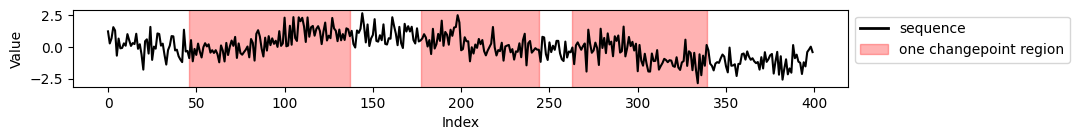

In [7]:
# Plot the sequence
plt.figure(figsize=(10, 1))
plt.plot(seq, label='sequence', color='black')

# Get the regions
regions = find_segments(labels, segment_length, min_region_length)

# Draw red rectangles for the segments found
for (rect_start, rect_end) in regions:
    plt.axvspan(rect_start, rect_end + segment_length, ymin=min(seq), ymax=max(seq), color='red', alpha=0.3)

# Show the plot with updated legend (only one entry for each label)
plt.xlabel('Index')
plt.ylabel('Value')

# Create custom legend entries
legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='sequence'),    # Black line for sequence
    Patch(color='red', alpha=0.3, label='one changepoint region')      # Red rectangle for highlighted regions
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), handlelength=2)

plt.show()